## **F1L Notebook 3 of 3: The KSQ**

This notebook follows the third part (3 of 3) of the FigureOne Lab Internship Emulator developed by Dean Lee. The code is modified from [Dean's repo](https://github.com/deanslee/FigureOneLab/tree/main/kinker). I will build on Dean's initial notebook to explore the KSQ.

The KSQ: Using available scRNA-seq data from cancer cell lines, how would you explore the use of the following FDA-approved antibody therapies in additional cancers?
* Trastuzumab: Targets HER2 and is used in the treatment of HER2-positive breast and gastric cancers.
* Bevacizumab: Targets VEGF and is used for a variety of cancers, including colorectal, lung, glioblastoma, breast, liver, and kidney cancer.

Same as part 2, I'll be uploading the output from the part 1 to be used directly as an input file. No need to re-process data.

In [5]:
# install additional packages
! pip install --quiet anndata scanpy igraph leidenalg decoupler
# !pip install --quiet decoupler

In [4]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
# import decoupler as dc
import seaborn as sns
import matplotlib.pyplot as plt
import re
from itertools import product
import matplotlib.colors as mcolors
import gc
pd.options.display.max_rows = 4000

# set up warning for cleaner code
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

from google.colab import drive
drive.mount('/content/drive')

# save for future code reproducibility
!pip freeze > requirements_scanpy.txt

Mounted at /content/drive


### 1. Load data
Processed data have been uploaded to Google Drive. No need to reprocessing. Archived code below:

```
def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat')
    #sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state)
    sc.tl.umap(adata, random_state=random_state)
    sc.tl.leiden(adata, random_state=random_state)
    return adata

adata = BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

sc.pl.umap(adata, color=['Indication'])

```

In [6]:
# upload previously processed data
adata = sc.read_h5ad('/content/drive/MyDrive/Datascience/kinker_etal_processed_data/240702_kinker_anndata_umap.h5ad')
adata

AnnData object with n_obs × n_vars = 53513 × 23081
    obs: 'CellLine', 'Pool', 'Indication', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Here are Dean's script. I'll be reproducing it with some modifications to fit limited in-memory processing. With limited amount of RAM, I can't have too many copies of `adata`. Because most plots and statistical analyses use log-scale expression, I'll only keep log2 expressin values. Processed data was already log1p transformed. No need to do it again

```
adata.layers['counts'] = adata.X.copy()
adata.layers['log2_counts'] = scipy.sparse.csr_matrix(np.log2(adata.layers['counts'].toarray()+1))

df = sc.get.obs_df(adata, keys=['ERBB2', 'VEGFA', 'VEGFB'], layer='log2_counts')
df['Indication'] = adata.obs['Indication']
sns.boxplot(data=df, x='Indication', y='ERBB2', showfliers=False)
sns.stripplot(data=df, x='Indication', y='ERBB2', color='black', size=0.5, jitter=True)
plt.xticks(rotation=90)
plt.show()

adata_breast = adata[adata.obs.Indication=='Breast Cancer'].copy()
df = sc.get.obs_df(adata_breast, keys=['ERBB2', 'VEGFA', 'VEGFB'], layer='log2_counts')
df['CellLine'] = adata_breast.obs['CellLine']
sns.boxplot(data=df, x='CellLine', y='ERBB2', showfliers=False)
sns.stripplot(data=df, x='CellLine', y='ERBB2', color='black', size=1, jitter=True)
plt.xticks(rotation=90)
plt.show()

adata_gastric = adata[adata.obs.Indication=='Gastric Cancer'].copy()
df = sc.get.obs_df(adata_gastric, keys=['ERBB2', 'VEGFA', 'VEGFB'], layer='log2_counts')
df['CellLine'] = adata_gastric.obs['CellLine']
sns.boxplot(data=df, x='CellLine', y='ERBB2', showfliers=False)
sns.stripplot(data=df, x='CellLine', y='ERBB2', color='black', size=1, jitter=True)
plt.xticks(rotation=90)
plt.show()

adata_lung = adata[adata.obs.Indication=='Lung Cancer'].copy()
df = sc.get.obs_df(adata_lung, keys=['ERBB2', 'VEGFA', 'VEGFB'], layer='log2_counts')
df['CellLine'] = adata_lung.obs['CellLine']
sns.boxplot(data=df, x='CellLine', y='ERBB2', showfliers=False)
sns.stripplot(data=df, x='CellLine', y='ERBB2', color='black', size=1, jitter=True)
plt.xticks(rotation=90)
plt.show()

```

> Some utils functions

Codes that are used multiple times are written as functions.

In [7]:
def check_genes_names_in_adata(adata, genes_to_check):
    """Find gene names in the adata dataset"""
    matching_genes = adata.var_names[adata.var_names.str.contains('|'.join(genes_to_check))]
    return matching_genes.tolist()

def create_long_df_for_genes(adata, genes_list):
    """Create a long dataframe for the gene list from adata"""

    df_wide = sc.get.obs_df(adata, keys=genes_list)
    df_wide['Indication'] = adata.obs['Indication']
    df_wide['CellLine'] = adata.obs['CellLine']
    # print(df_wide.head())
    # print('\n')

    df_long = pd.melt(df_wide.reset_index(names=["cell_id"]),
                      id_vars=['cell_id','Indication', 'CellLine'],
                      value_vars=genes_list,
                      var_name='Gene', value_name='Expression')
    print(df_long.head())
    return(df_long)

def high_exp_cell_lines(df_long):
    """Find top 5 cell lines with highest gene expression in df_long"""

    df_describe = df_long.groupby(['Gene','Indication'])['Expression'].describe()
    # print(df_describe)

    # Sort by median and get top 3 for each gene
    top_5_mean = df_describe.sort_values('mean', ascending=False).groupby('Gene').head(5)

    # Print the result
    for gene, data in top_5_mean.groupby('Gene'):
        print(f"\nTop 5 Cell Lines with Highest Mean Expression for {gene}:")
        print(data[['mean']].to_string())  # Print median values
        # print("\n")

def plot_exp_by_cell_lines(df_long):
    """Plot expression by cell lines"""

    genes = df_long['Gene'].unique()  # Get unique gene names
    num_genes = len(genes)

    fig, axes = plt.subplots(nrows=num_genes, ncols=1, figsize=(6, 4 * num_genes))  # Create subplots

    for i, gene in enumerate(genes):
        ax = axes[i]  # Get the current subplot axis
        data = df_long[df_long['Gene'] == gene]  # Filter data for the current gene

        sns.boxplot(data=data, x='Indication', y='Expression', showfliers=False, ax=ax)  # Box plot
        sns.stripplot(data=data, x='Indication', y='Expression', color='black', dodge=True, size=0.5, ax=ax)  # Strip plot

        ax.set_title(f"Indication vs Expression for {gene}")  # Set subplot title
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=8)  # Rotate x-axis labels

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()  # Display the plot

def plot_exp_by_cell_line_in_cancer_type(df_long, cancer_type_list):
    """Plot exp by cell line within each cancer cell type"""
    num_types = len(cancer_type_list)

    fig, axes = plt.subplots(nrows=num_types, ncols=1, figsize=(6, 4 * num_types))  # Create subplots

    for i, ctype in enumerate(cancer_type_list):
        ax = axes[i]  # Get the current subplot axis
        data = df_long[df_long['Indication'] == ctype]  # Filter for a cancer type to plot
        used_cell_lines = data['CellLine'].unique()  # Get unique cell lines for the cancer type

        sns.boxplot(data=data, x='CellLine', y='Expression', showfliers=False, order=used_cell_lines, ax=ax)  # Box plot
        sns.stripplot(data=data, x='CellLine', y='Expression', color='black', order=used_cell_lines, dodge=True, size=0.5, ax=ax)  # Strip plot

        ax.set_title(f"Cell Line vs Expression for {ctype}")  # Set subplot title
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=8)  # Rotate x-axis labels

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()  # Display the plot

### 2. Exploring `ERBB2` expression across cancer cell lines.


ERBB2 promotes oncogenic phenotypes when it is overexpressed and activated. Activation of ERBB2 is either by homodimerization (usually via overexpression) or heterodimerization with activated EGFR (ERBB1), ERBB3, and ERBB4 by ligands.

It is important to note that there are many mechanism of resistance to Trastuzumab. One that I would like to mention is the heterodimerization of ERBB2/ERBB3. Trastuzumab cannot bind to these activated heterodimers likely because of epitope masking. This one is important because we can perform a simple correlation analysis to explore ERBB receptor co-expression in this dataset.


['EGFR', 'EGFR-AS1', 'ERBB2', 'ERBB2IP', 'ERBB3', 'ERBB4']
                 cell_id      Indication       CellLine   Gene  Expression
0  AAACCTGAGACATAAC-1-18     Lung Cancer  NCIH2126_LUNG  ERBB2         0.0
1  AAACCTGCACAACGCC-1-18  Thyroid Cancer  SW579_THYROID  ERBB2         0.0
2  AAACCTGCAGACAAGC-1-18     Skin Cancer       C32_SKIN  ERBB2         0.0
3  AAACCTGCAGCTCGAC-1-18  Thyroid Cancer  SW579_THYROID  ERBB2         0.0
4  AAACCTGCATGGATGG-1-18     Lung Cancer   NCIH446_LUNG  ERBB2         0.0

Top 5 Cell Lines with Highest Mean Expression for EGFR:
                               mean
Gene Indication                    
EGFR Esophageal Cancer     0.860142
     Head and Neck Cancer  0.586554
     Thyroid Cancer        0.579369
     Kidney Cancer         0.561216
     Bile Duct Cancer      0.555106

Top 5 Cell Lines with Highest Mean Expression for ERBB2:
                                      mean
Gene  Indication                          
ERBB2 Breast Cancer               0.64

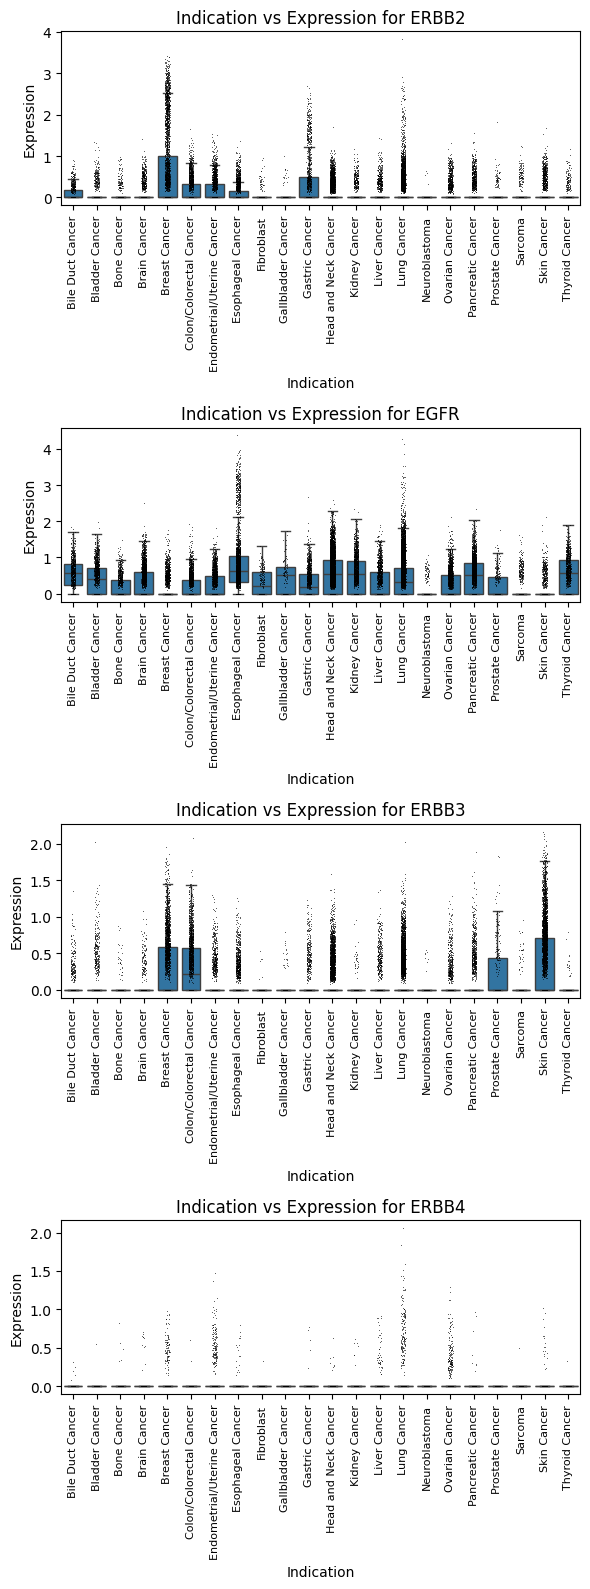

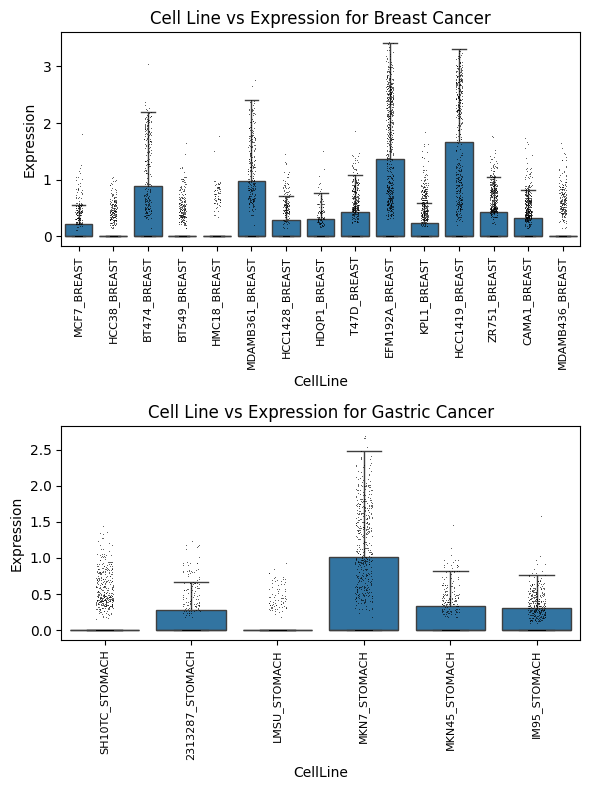

In [8]:
# ERBB2 gene list
gene_list_ERBB2 = ['ERBB2', 'EGFR', 'ERBB3', 'ERBB4']

# check if genes of interest exist in adata and the right names?
print(check_genes_names_in_adata(adata, gene_list_ERBB2))

# create a long dataframe for the gene list
df_long_ERBB2 = create_long_df_for_genes(adata, gene_list_ERBB2)

# print out cell lines with highest mean expression
high_exp_cell_lines(df_long_ERBB2)

plot_exp_by_cell_lines(df_long_ERBB2)

# Current indication
plot_exp_by_cell_line_in_cancer_type(df_long_ERBB2, ['Breast Cancer', 'Gastric Cancer'])

**ERBB2 and related receptors expression across cancer cell lines**

1. Using `describe()` to quickly obtain summary statistics, it is clear that the highest expression of HER2 or ERBB2 is found in breast cancer and gastric cancer cells, followed by colon/colorectal, endometrial/uterine, and esophageal cancers. Recall that Trastuzumab is used for treating breast and gastric cancer.
2. Box plots recapitulates the patterns of ERBB2 expression levels in breast, and cancer colon/colorectal, endometrial/uterine, and esophageal cancers. However, some other cancer types that have low average ERBB2 levels appears to have subpopulation with high ERBB2 transcripts. Thus, we can infer that high-level ERBB2 expression is mostly cell-line/subpopulation-specific.
3. Indeed, when we plot breast and gatric cancer by cell lines, not all cell lines have high ERBB2 expression. Remember since Trastuzumab binds specifically too ERBB2, cells with low ERBB2 expression is not a good candidate for additional Trastuzumab application.

Thus, it is plausible that Trastuzumab may work with colon/colorectal, endometrial/uterine, and esophageal cancers. Follow-up with specific cell lines can give us more information. Examples include
* Majority of Colon/Colorectal cancer cell lines (except SNUC4)
* HEC6 cell line for Endometrial/Uterine Cancer
* KYSE520 for Esophageal cancers

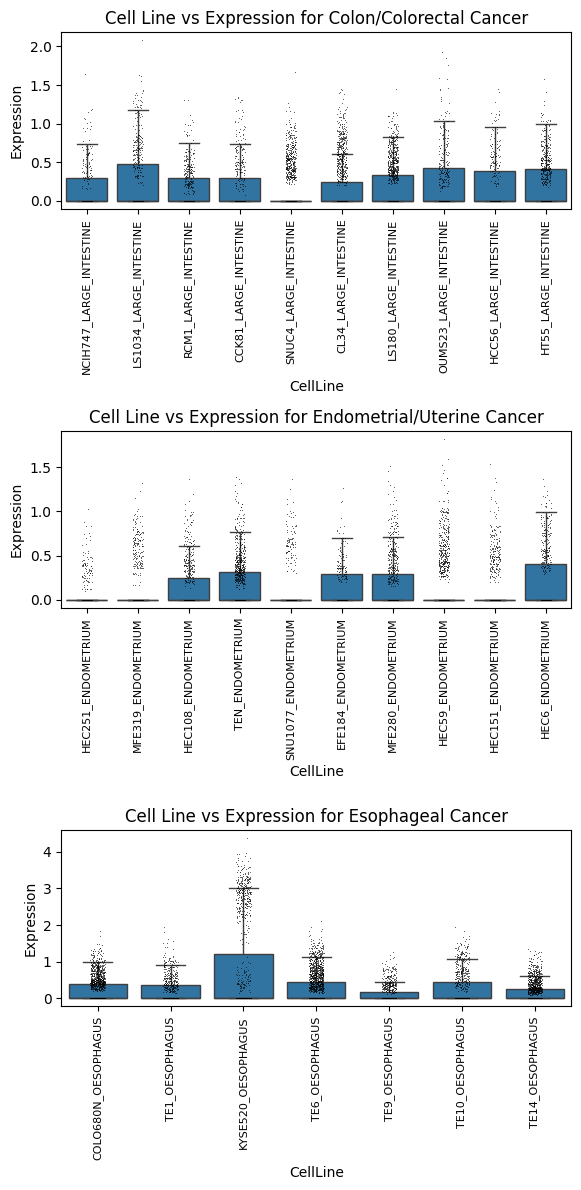

In [9]:
# Potential indication
plot_exp_by_cell_line_in_cancer_type(df_long_ERBB2, ['Colon/Colorectal Cancer', 'Endometrial/Uterine Cancer', 'Esophageal Cancer'])

### 3. Exploring VEGF expression across cancer cell lines.
VEGF is a secreted protein. Bevacizumab works on circulating VEGF, specifically for **VEGFA**, preventing VEGF ligands from reaching VEGFA receptors on endothelial cell. This leads to a reduction in microvascular growth of tumor blood vessels.

Because of this mechanism, Bevacizumab has potential applications for non-endothelial cancer cells that express VEGFA receptors. So we should look into VEGFA receptor-positive cells.

Some more information on VEGF receptors. VEGF-A binds to VEGFR-1 (Flt1) and VEGFR-2 (KDR/Flk-1). VEGFR-2 appears to mediate almost all of the known cellular responses to VEGF. So we should look for both FLT1 and KDR genes

['FLT1', 'KDR', 'PKDREJ', 'VEGFA']
                 cell_id      Indication       CellLine   Gene  Expression
0  AAACCTGAGACATAAC-1-18     Lung Cancer  NCIH2126_LUNG  VEGFA    0.303059
1  AAACCTGCACAACGCC-1-18  Thyroid Cancer  SW579_THYROID  VEGFA    0.585291
2  AAACCTGCAGACAAGC-1-18     Skin Cancer       C32_SKIN  VEGFA    0.000000
3  AAACCTGCAGCTCGAC-1-18  Thyroid Cancer  SW579_THYROID  VEGFA    0.874560
4  AAACCTGCATGGATGG-1-18     Lung Cancer   NCIH446_LUNG  VEGFA    0.000000

Top 5 Cell Lines with Highest Mean Expression for FLT1:
                         mean
Gene Indication              
FLT1 Bone Cancer     0.084012
     Fibroblast      0.075051
     Ovarian Cancer  0.025872
     Brain Cancer    0.025683
     Neuroblastoma   0.024449

Top 5 Cell Lines with Highest Mean Expression for KDR:
                           mean
Gene Indication                
KDR  Skin Cancer       0.012565
     Prostate Cancer   0.011270
     Thyroid Cancer    0.009416
     Ovarian Cancer    0.008872


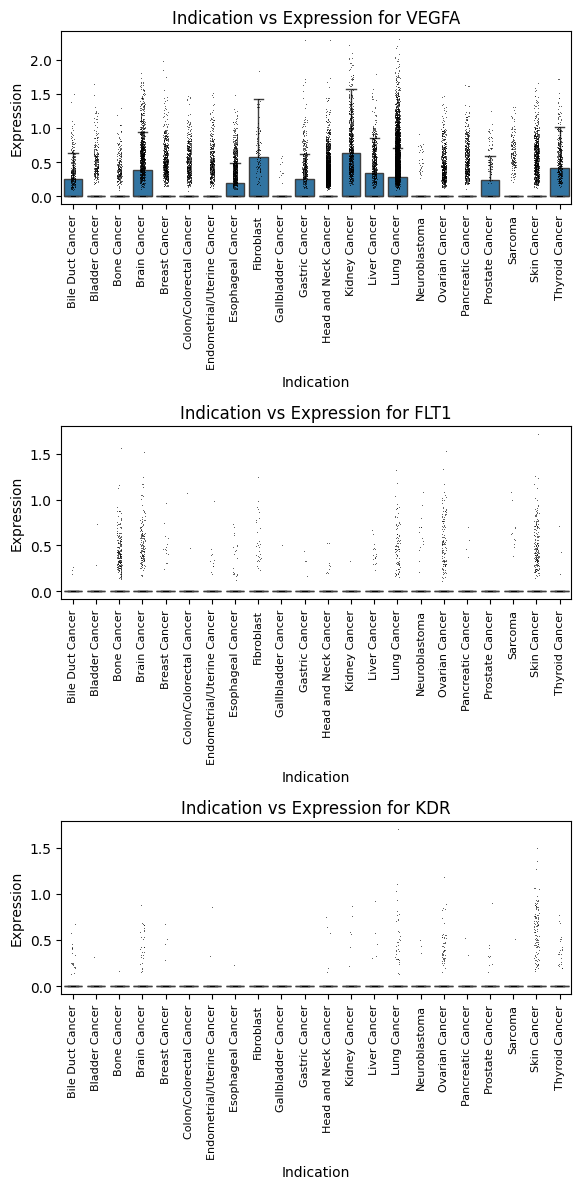

VEGFA


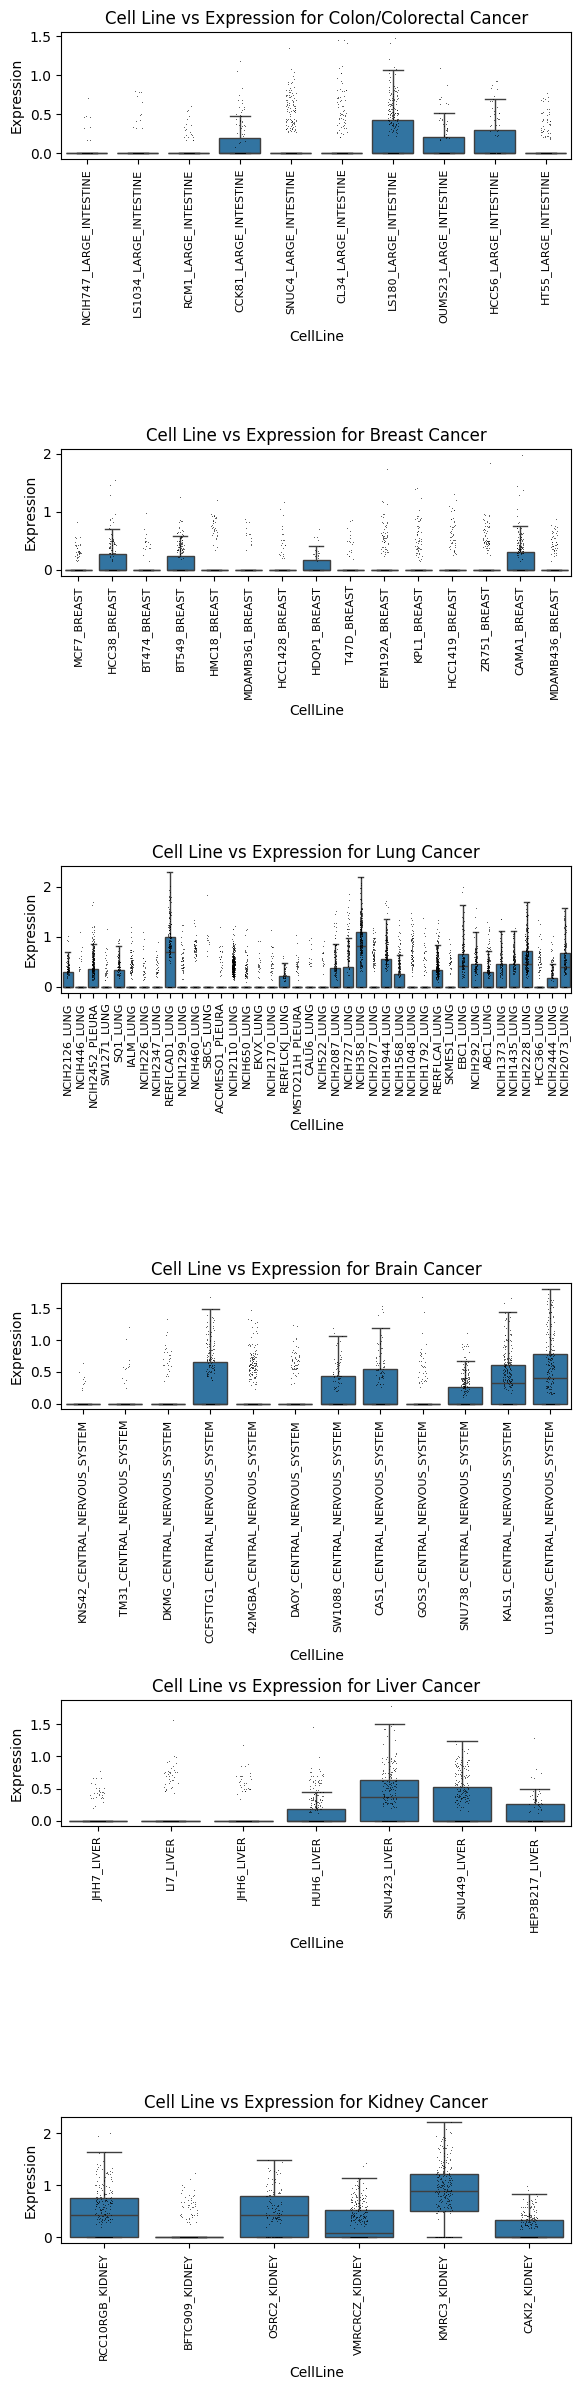

KDR


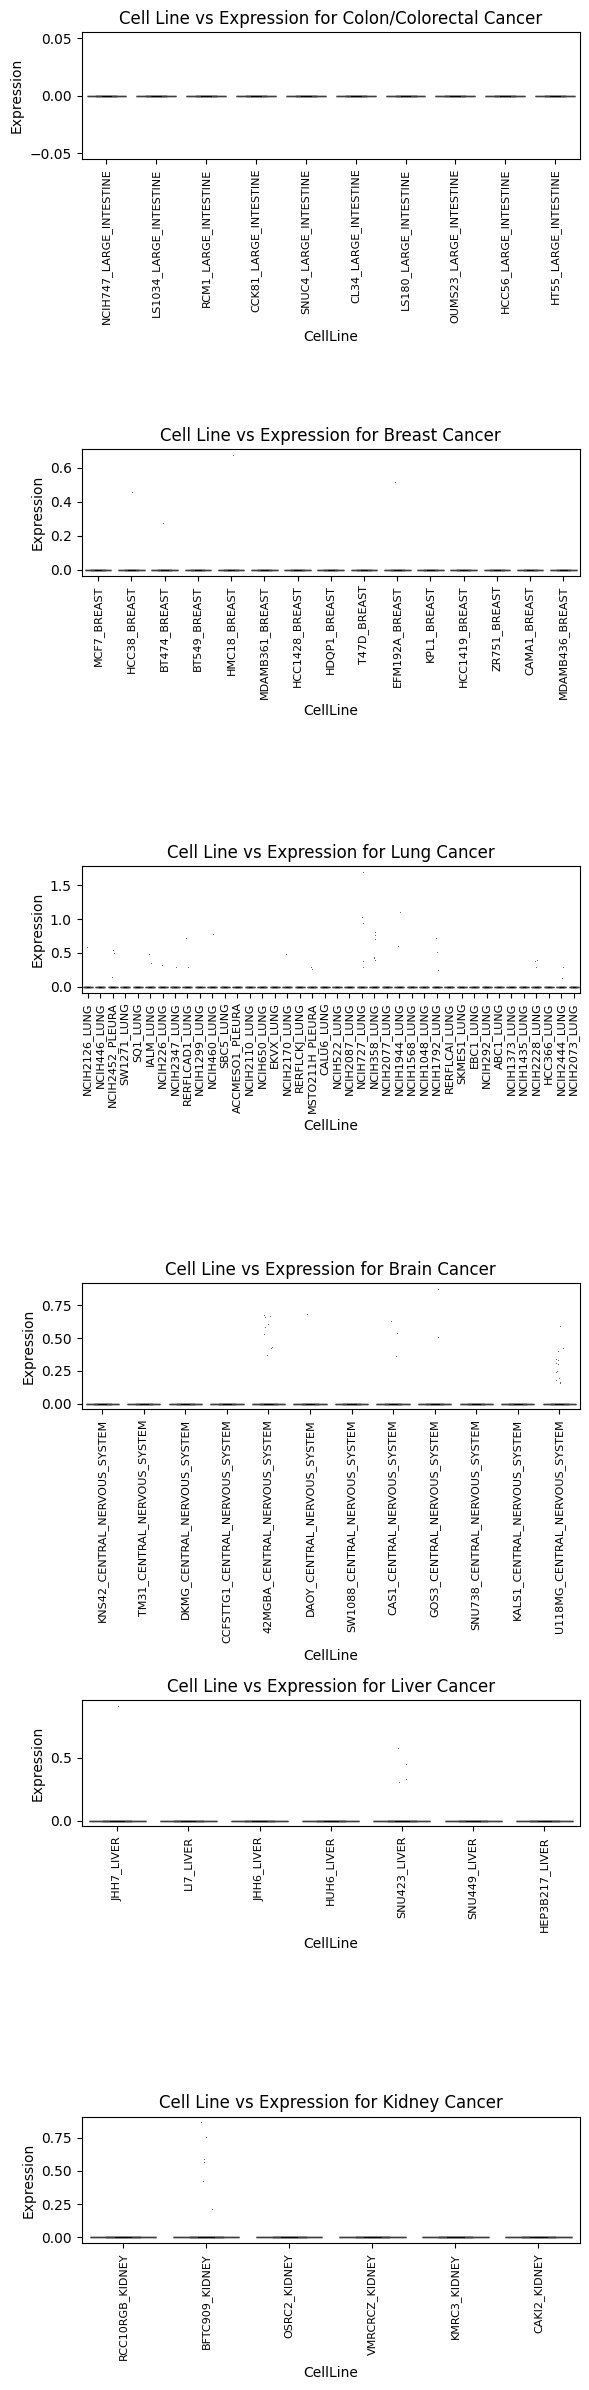

In [14]:
# VEGF gene list
gene_list_VEGF = ['VEGFA', 'FLT1', 'KDR']

# check if genes of interest exist in adata and the right names?
print(check_genes_names_in_adata(adata, gene_list_VEGF))

# create a long dataframe for the gene list
df_long_VEGF = create_long_df_for_genes(adata, gene_list_VEGF)

# print out cell lines with highest mean expression
high_exp_cell_lines(df_long_VEGF)

plot_exp_by_cell_lines(df_long_VEGF)

# Current indication
current_indication_VEGF = ['Colon/Colorectal Cancer', 'Breast Cancer', 'Lung Cancer', 'Brain Cancer', 'Liver Cancer', 'Kidney Cancer']
print("VEGFA")
plot_exp_by_cell_line_in_cancer_type(df_long_VEGF[df_long_VEGF['Gene'] == 'VEGFA'], current_indication_VEGF)
print("KDR")
plot_exp_by_cell_line_in_cancer_type(df_long_VEGF[df_long_VEGF['Gene'] == 'KDR'], current_indication_VEGF)

* Note is that Thyroid Cancer is among the top 5 with highest VEGFA expression. So we can explore this too for Bevacizumab.
* Prostate Cancer and Skin Cancer have high KDR expressioon while Bone Cancer and Ovarian Cancer has high FTL1 expression. So we should look into them too.

VEGFA


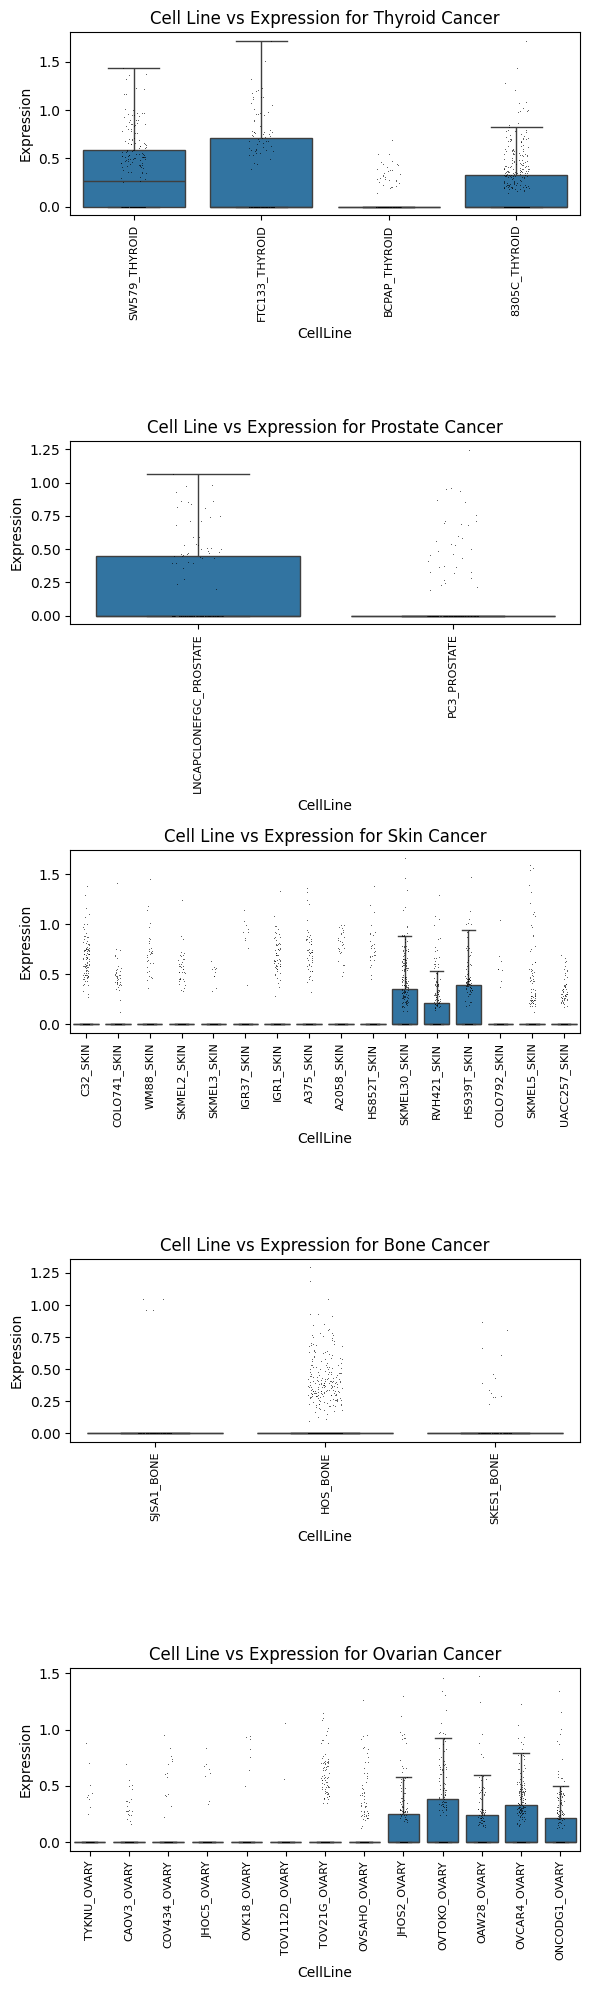

KDR


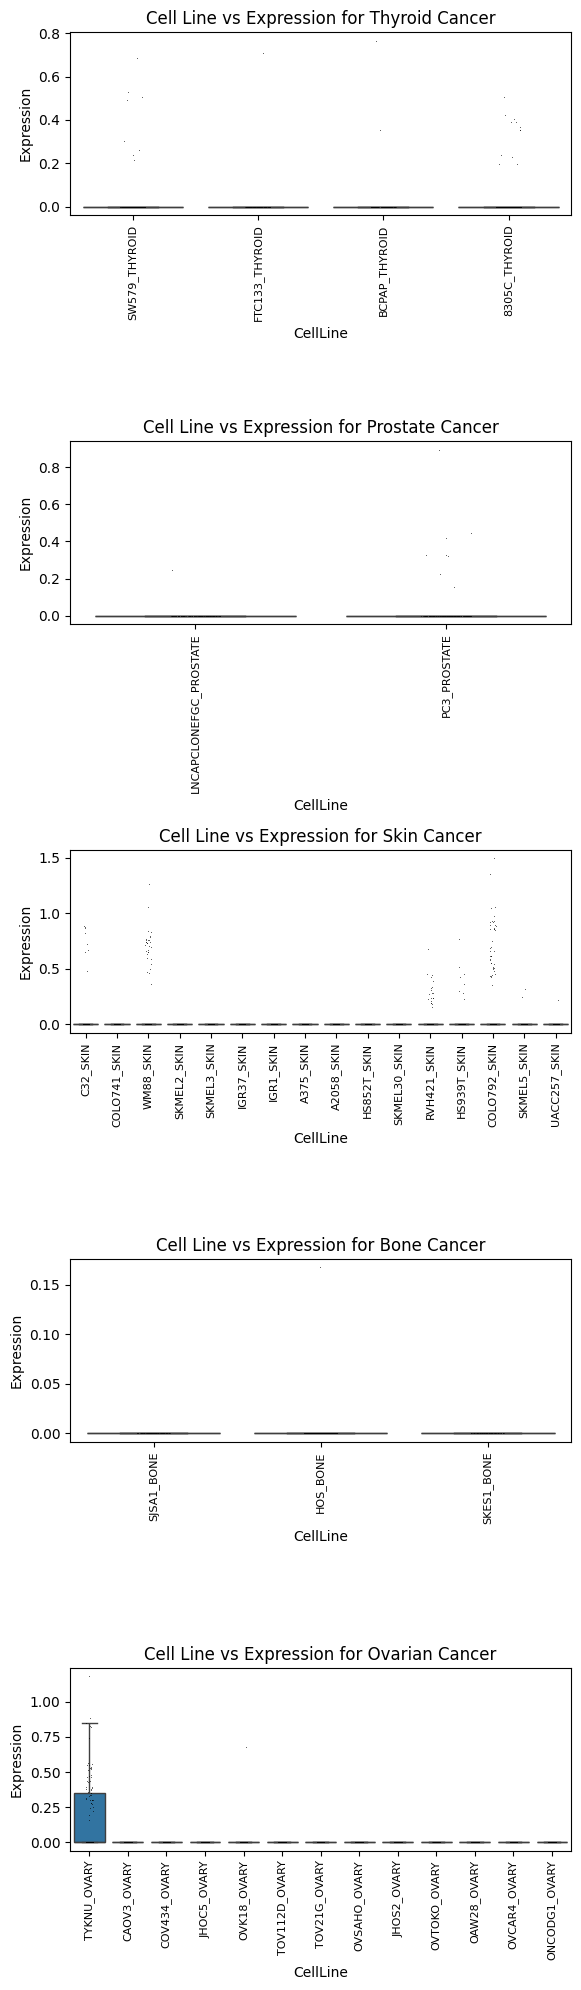

In [15]:
print("VEGFA")
plot_exp_by_cell_line_in_cancer_type(df_long_VEGF[df_long_VEGF['Gene'] == 'VEGFA'], ['Thyroid Cancer', 'Prostate Cancer', 'Skin Cancer', 'Bone Cancer', 'Ovarian Cancer'])
print("KDR")
plot_exp_by_cell_line_in_cancer_type(df_long_VEGF[df_long_VEGF['Gene'] == 'KDR'], ['Thyroid Cancer', 'Prostate Cancer', 'Skin Cancer', 'Bone Cancer', 'Ovarian Cancer'])